# Dataset - Kaggle
[2018 data science bowl](https://www.kaggle.com/competitions/data-science-bowl-2018/)

In [5]:
# import libraries
import tensorflow as tf
import os
import random
import numpy as np
import zipfile
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt


In [6]:
# unzipping the train data
zip_file_path = '/content/drive/MyDrive/unet/stage1_train.zip'

output_dir = '/content/drive/MyDrive/unet/stage1_train'
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"Unzipped the file into {output_dir} folder.")


Unzipped the file into /content/drive/MyDrive/unet/stage1_train folder.


In [3]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/MyDrive/unet/stage1_train/'
TEST_PATH = '/content/drive/MyDrive/unet/stage1_test/'

Resizing training images and masks


100%|██████████| 670/670 [10:31<00:00,  1.06it/s]


Resizing test images


100%|██████████| 65/65 [00:33<00:00,  1.96it/s]


Done!


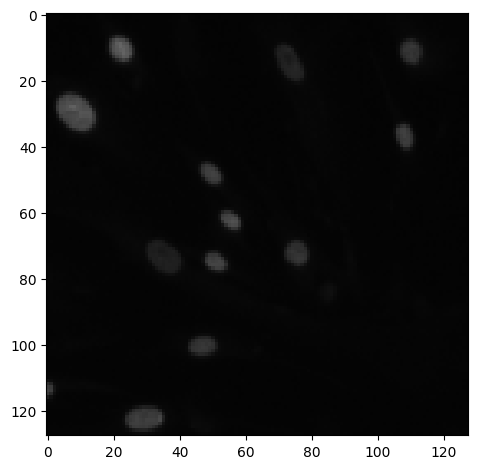

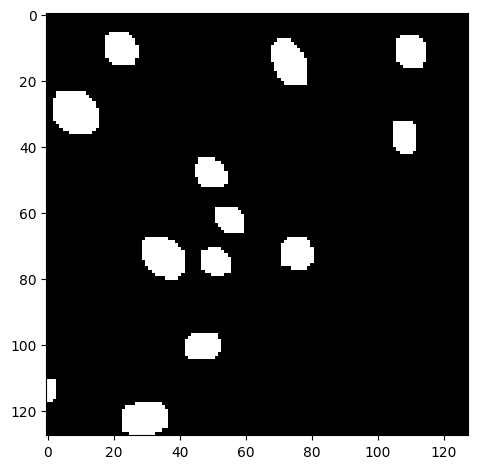

In [9]:
# Resizing images to a fixed size and preprocessing the masks to be binary (0 or 1).
# This is necessary because the U-Net model expects input images of uniform size and binary masks.

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()


In [4]:
# Defining the U-Net architecture
# U-Net consists of a contracting path (downsampling) followed by an expansive path (upsampling).
# The skip connections concatenate features from the downsampling path to the upsampling path, which helps in better localization of features.

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.6923 - loss: 0.6506 - val_accuracy: 0.7843 - val_loss: 0.3403
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7985 - loss: 0.3605 - val_accuracy: 0.9255 - val_loss: 0.1914
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9340 - loss: 0.1774 - val_accuracy: 0.9369 - val_loss: 0.1602
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9440 - loss: 0.1460 - val_accuracy: 0.9453 - val_loss: 0.1430
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9529 - loss: 0.1235 - val_accuracy: 0.9478 - val_loss: 0.1396
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9495 - loss: 0.1349 - val_accuracy: 0.9539 - val_loss: 0.1177
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9547 - loss: 0.1186 - val_accuracy: 0.9579 - val_loss: 0.1133
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9556 - loss: 0.1176 - val_accuracy: 0.9567 - v

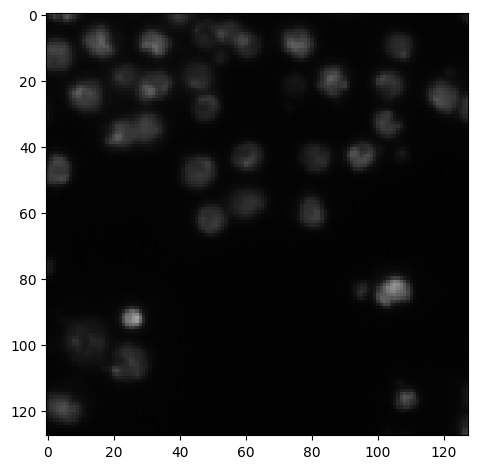

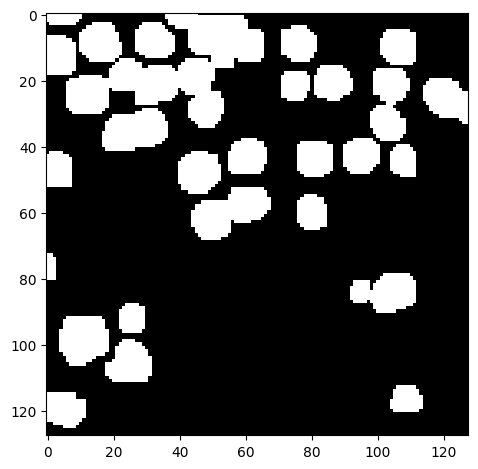

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


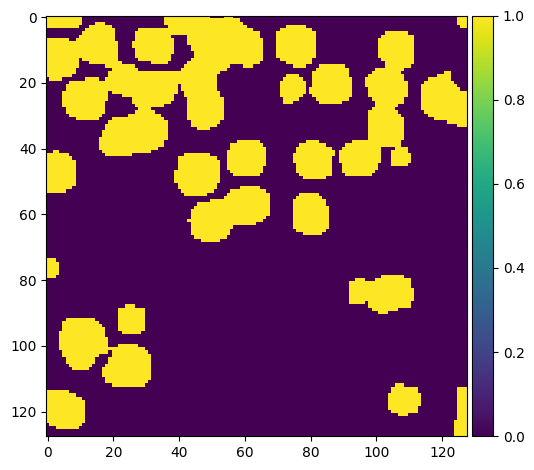

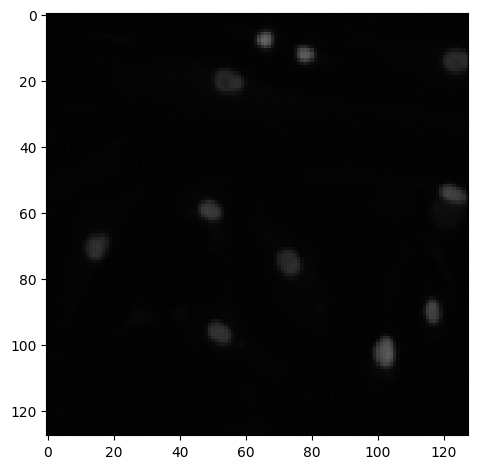

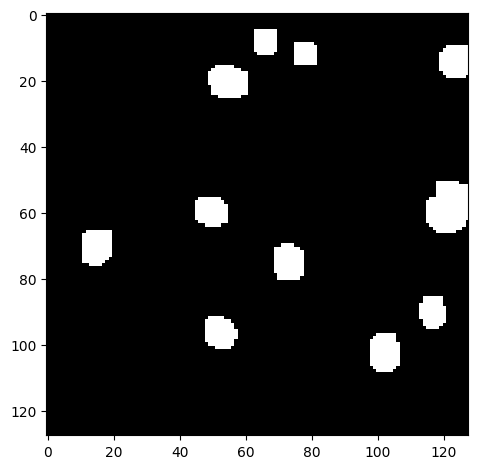

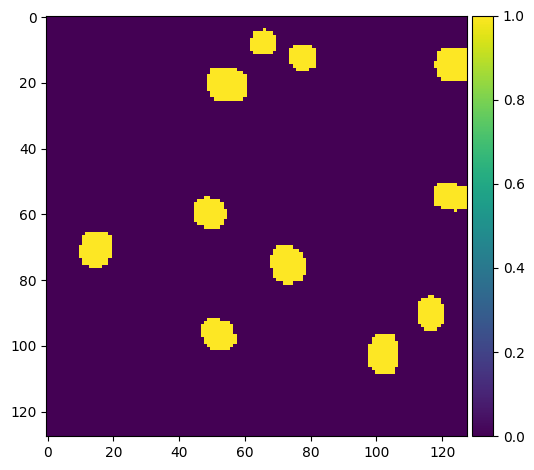

In [12]:
################################
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/unet/cell_segmentation_nuclei.keras', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=12, callbacks=callbacks)

####################################
# Making predictions on the test set and visualizing the results.
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()